# ColPali: Generate your own similarity maps 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from PaliGemma-3B to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

Using ColPali removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document.

ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColPali’s strong OCR capabilities and chart understanding.

![Similarity map examples](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/interpretability/similarity_maps.jpeg?raw=true)

The following notebook guide you through how to generate your own similarity maps.

## Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac).


## Login to a HuggingFace account

Because ColPali uses the [PaliGemma3B](https://huggingface.co/google/paligemma-3b-mix-448) checkpoints, you need to accept its terms and conditions before using it. Once accepted, use the following cell to login to your HuggingFace account.

In [1]:
!pip install -q -U huggingface_hub
from huggingface_hub import login

login()

## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali. This package also contains the training code (processor, collator, trainer...) for fine-tuning ColPali on your own dataset.

In [2]:
!pip install -q -U "colpali-engine>=0.3.2,<0.4.0"

In [3]:
import pprint
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, cast

import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

/Users/tony/Desktop/colpali-cookbooks/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## A few custom utils

In [4]:
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image


@dataclass(kw_only=True)
class ViTConfig:
    """
    Configuration class for the vanilla Vision Transformer (ViT) encoder, i.e. a vision encoder
    that has a fixed patch size and resolution.

    Args:
        patch_size: int
            The size of the square patches extracted from the input image.
        resolution: int
            The resolution of the input image.
    """

    patch_size: int
    resolution: int

    @property
    def n_patches(self) -> Tuple[int, int]:
        if self.resolution % self.patch_size != 0:
            raise ValueError(f"Resolution {self.resolution} is not divisible by patch size {self.patch_size}")

        n_patches_per_dim = self.resolution // self.patch_size

        return (n_patches_per_dim, n_patches_per_dim)

## Load ColPali

Click on the following link to open the model card for [`vidore/colpali-v1.2`](https://huggingface.co/vidore/colpali-v1.2).

In [5]:
model_name = "vidore/colpali-v1.2"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

# Load the ViT config
vit_config = ViTConfig(patch_size=14, resolution=448)  # for ColPali only

Using device: mps


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


## Load image from filepaths

First, upload your image in the Google Colab environment, then replace the following variable values with your own.

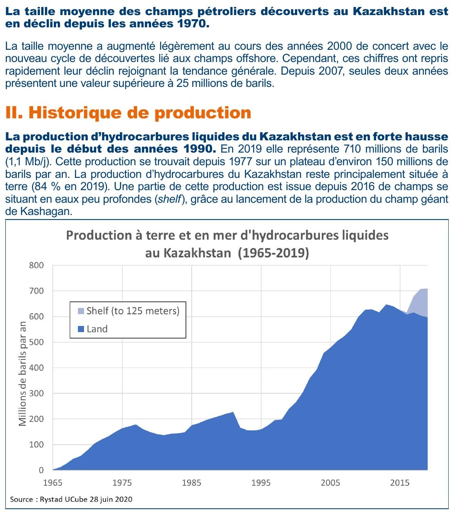

In [6]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("shift_kazakhstan.jpg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"

# =========================================================================

assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image
scale_image(image, 512)

## Preprocess and embed the query and the image

In [7]:
# Preprocess inputs
batch_image = processor.process_images([image]).to(device)
batch_query = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_image)
    query_embeddings = model.forward(**batch_query)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


## Get the per-token similarity maps

First step is to compute all the similarity scores between the query tokens and the image patches. Then, we reshape the resulting tensor to make the image structure appear clearly in the tensor shape.

In [8]:
# Remove the special tokens from the output (ColPali-specific)
image_embeddings = image_embeddings[:, : processor.image_seq_length, :]  # (1, n_patches_x * n_patches_y, dim)

# Generate the similarity maps
similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings,
    query_embeddings,
    n_patches=vit_config.n_patches,
)

The following cell will display the tokens of the query. For clarity, we will ask the user to select the token for which they want to visualize the similarity map.

In [9]:
# Use this cell output to choose a token using its index
query_tokens = processor.tokenizer.tokenize(processor.decode(batch_query.input_ids[0]))

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?',
 20: '<pad>',
 21: '<pad>',
 22: '<pad>',
 23: '<pad>',
 24: '<pad>',
 25: '<pad>',
 26: '<pad>',
 27: '<pad>',
 28: '<pad>',
 29: '<pad>',
 30: '\n'}


## Select the query token of interest

In [10]:
# Choose a token using its index
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[0, token_idx, :, :]

Selected token: `▁Kazakhstan`


## Visualize the similarity map for the current query token

The brighter the patch, the higher similarity score it has with the selected token. This similarity map exhibits OCR capabilities and chart understanding of ColPali. For instance, the patch containing the selected query token should be clearly highlighted in the similarity map.

/var/folders/lf/g933cgq12tz25msclq229tk40000gn/T/ipykernel_59985/1595989574.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


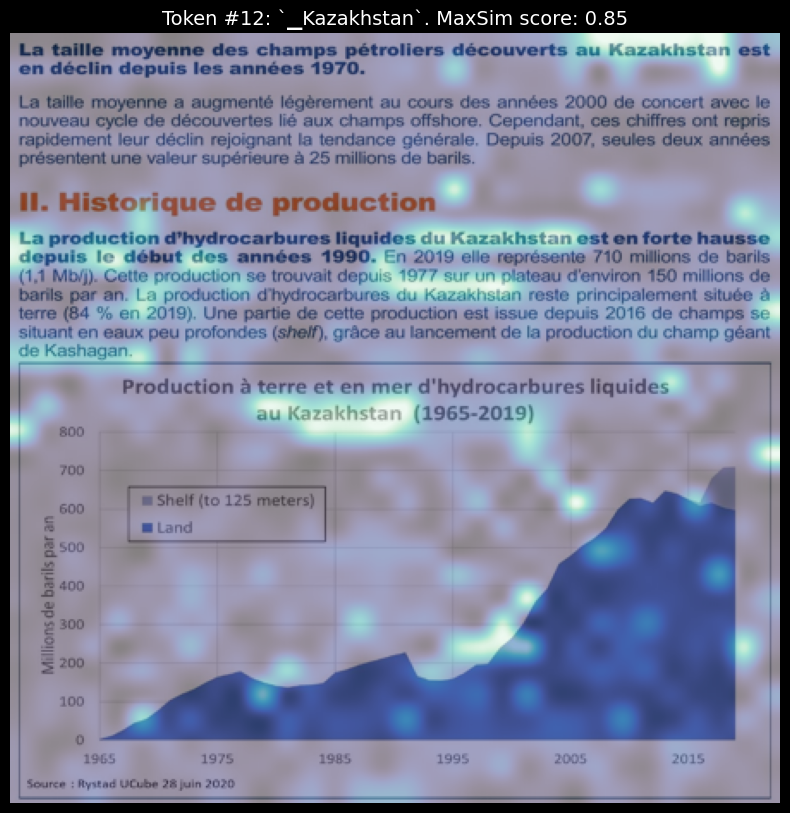

In [11]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    resolution=(vit_config.resolution, vit_config.resolution),
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[0, token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig.show()

**Additional note:** You should notice a few white patches with high similarity scores. This behavior might first seem surprising as the white patches should not carry a meaningful signal from the original images. We believe the vectors associated with these patches share a similar role with the ViT registers [(Darcet et al., 2023)](https://doi.org/10.48550/arXiv.2309.16588), i.e. these patches were repurposed for internal computations and stored the global information from the whole image.

## Bonus: Generate similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens. This function will save the similarity maps in the `output_dir` directory.

/Users/tony/Desktop/colpali-cookbooks/.venv/lib/python3.10/site-packages/colpali_engine/interpretability/similarity_maps.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


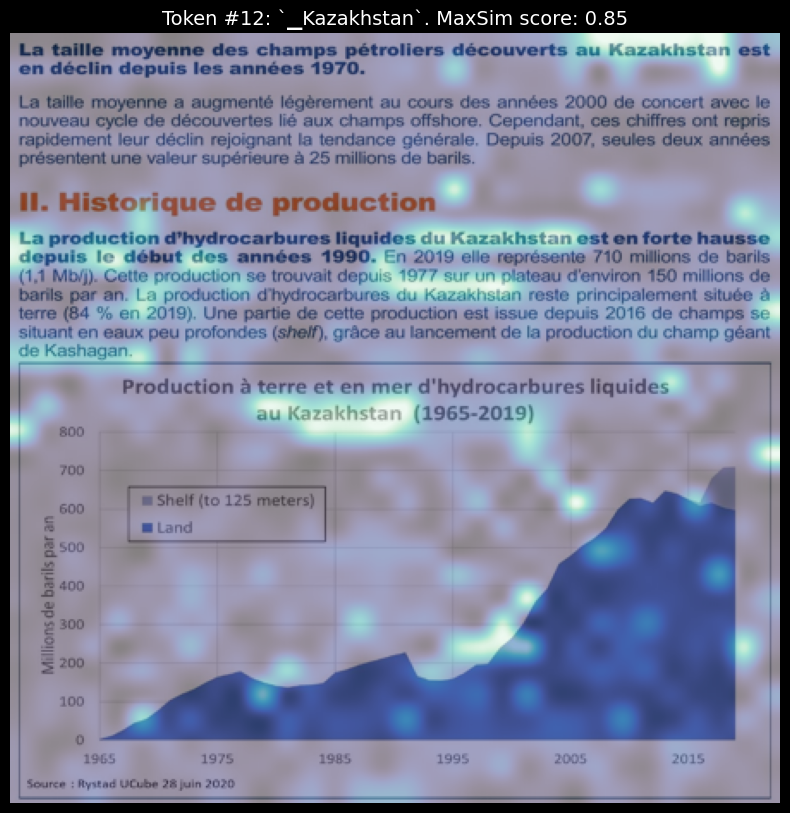

In [12]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    resolution=(vit_config.resolution, vit_config.resolution),
    figsize=(8, 8),
    show_colorbar=False,
)

plots[token_idx][0]